<h1>Модель развития города с естественным приростом населения</h1>
<h3>Работу выполнил студент 3-го курса ЭФ СПбГУ гр. 20.б03-э Шатров Д.И. в 2023 г.<h3>

In [74]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import pandas as pd
from math import sqrt
from IPython.display import display, Math
from scipy import linspace
import random
from collections import defaultdict
import statsmodels.tsa.stattools

Переменные состояния:

* $R_t$ - население к началу года $t$.
* $S_t$ - жилой фонд к началу $t$
* $Y_t$ - число рабочих к началу $t$
* $\omega_t$ - прирост трудоспособного населения к началу $t$
* $\nu_t$ - убыль трудоспособного населения к началу $t$

Переменные управления:

* $Z_t$ - ввоз в город строительных рабочих за год $t$.
* $K_t$ - доля нестроительного населения, обучаемая строительной специальности за год $t$.

Параметры:

* $B_s$ -- доля жилфонда, выбывающего за год из эксплуатации.
* $A$ - годовая производительность одного рабочего.
* $B_Y$ - доля строительных рабочих, выбывающих за год (становящихся нестроителями)}

Функциональная зависимость:
* $R_{t+1}=R_t+Z_t+\omega_t+\nu_t$ - население.;
* $S_{t+1}=S_t-B_SS_t+AY_t$ - жилой фонд
* $Y_{t+1}=Y_t-B_YY_t+K_t(R_t-Y_t)+Z_t$ -- сл. в-р заказов за промежуток $[t,t+1)$ -- кол-во строителей
<br><br>
Случайные величины $\omega_t,\nu_t$ задаются как произведение $R_t$ на нормальные с.в. $\omega_t\in\mathcal{N}(\mu_1,\sigma^2_1),\nu_t\in\mathcal{N}(\mu_2,\sigma^2_2)$. Считается, что в среднем они должны составлять не более 5% от текущего населения.<br><br>
Класс $gorod$ позволяет моделировать город для работы с моделью развития города. Метод $control$ обновляет состояние города в зависимости от введённого управления. Метод $housing$ возвращает обеспеченность населения жильём в смысле кв. м. на чел.  

In [110]:
class gorod:
    def __init__(self, B_S = 0.005, B_Y = 0.005, A = 20, R = 3000000, S = 15000000, Y = 50000):
        self.B_S = B_S
        self.B_Y = B_Y
        self.A = A
        self.R = R
        self.S = S
        self.Y = Y
    def control(self, Z, K, mu_1 = 0, sigma_1 = 0.025, mu_2 = 0, sigma_2 = 0.025):
        assert(mu <= 0.01 and mu>= 0 for mu in [mu_1, mu_2])
        omega = self.R * np.random.normal(mu_1, sigma_1)
        nu = self.R * np.random.normal(mu_2, sigma_2)
        self.S = self.S - self.B_S * self.S + self.A * self.Y
        self.Y = self.Y - self.B_Y * self.Y + K * (self.R - self.Y) + Z
        self.R = self.R + Z + omega + nu
        for p in [self.S, self.Y, self.R]:
            if p < 0 :
                p = 0
        return None
    def housing(self):
        return self.S/self.R

In [111]:
t = gorod()
t.housing()

5.0

<h3>Задача №1. Достижение стационарного уровня обеспечения жильём к моменту времени</h3>
    Будем считать задачу решённой, если на горизонте планирования в 150 лет процесс, реализацией которого является $housing$, стационарен в слабом смысле.<br><br>
    Функция $hLT$ принимает на вход город, параметры управления и горизонт прогнозирования, на котором применяется это управление. Возвращаемое значение - массив уровней обеспечения жильём на заданном горизонте прогнозирования.

In [112]:
def hLT(cite, Z, K, h = 200):
    assert isinstance(cite, gorod) and (k>=0 for k in [Z,K,h])
    i = 0
    srhist = [cite.housing()]
    while i < h:
        i+=1
        cite.control(Z,K)
        #print(cite.housing())
        srhist.append(cite.housing())
    return srhist

Функция $hda$ позволяет исследовать ряд уровней обеспеченности жильём на стационарность: выводит график ряда, проводит для последних 150-ти наблюдений статистические тесты на единичные корни.

In [113]:
def hda(srhist):
    assert(len(srhist)>=150)
    fig, ax = plt.subplots(figsize=(12, 6))
    xs = [x for x in range(len(srhist))]
    ax.plot(srhist, color='#CC0000', label='Sine wave', linewidth = 2.5)
    plt.ylabel("Обеспеченность жильём, кв.км/чел.")
    plt.xlabel("Годы")
    plt.title("Прогноз обеспеченности жильём")
    plt.xlim([0, len(srhist)])
    plt.show()
    testres = pd.DataFrame(columns = ["Тест","H_0","Статистика","p-value"])
    adfstat, p_adf,_,_,_,_ = statsmodels.tsa.stattools.adfuller(x = srhist[-150:], regression = "ct")
    kpstat, p_kpss,_,_ = statsmodels.tsa.stattools.kpss(x = srhist[-150:], regression = "ct")
    adfres = {"Тест":"ADF", 
                    "H_0":"DS",
                    "Статистика":adfstat,
                    "p-value":p_adf}
    kpssres = {"Тест":"KPSS", 
              "H_0":"TS",
              "Статистика":kpstat,
              "p-value":p_kpss}
    testres = pd.concat([testres, pd.DataFrame([adfres]), pd.DataFrame([kpssres])], ignore_index=True)
    if p_adf < 0.02 and p_kpss >0.02:
        print("Результаты тестов свидетельствуют о том, что стационарный уровень обеспечения жильём достигнут.")
    else:
        print("Результаты тестов не позволяют сказать, что стационарный уровень обеспечения жильём достигнут.")
    return testres

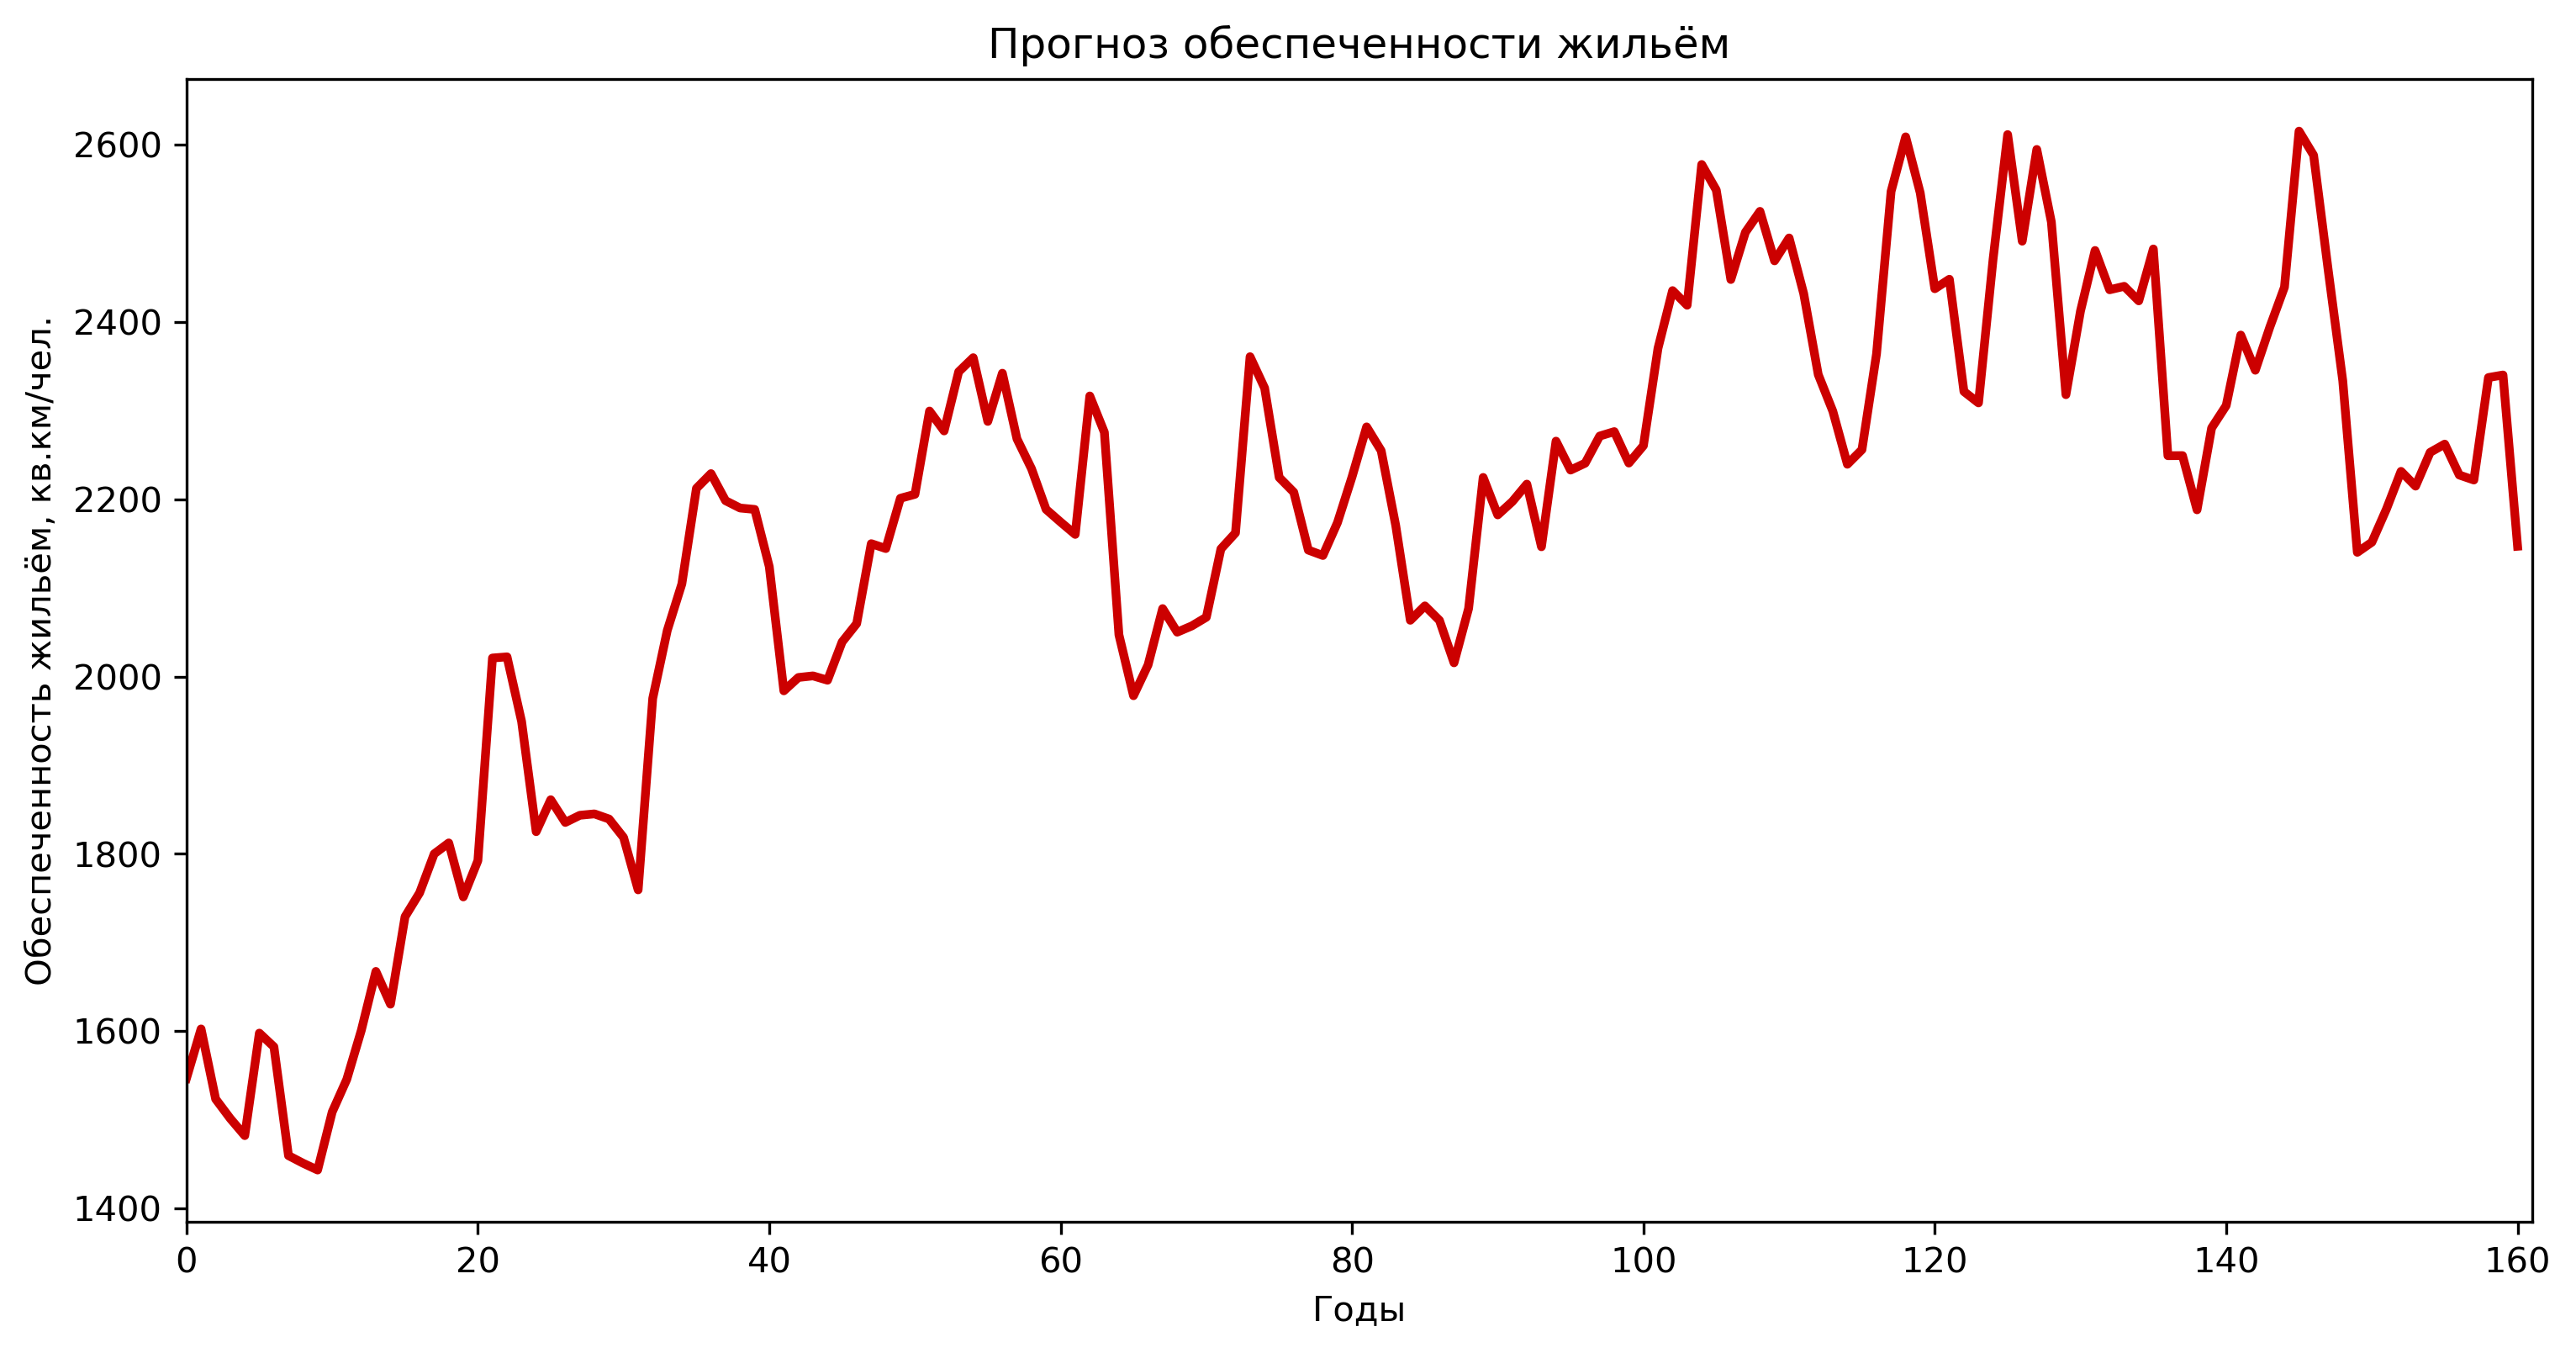

Результаты тестов не позволяют сказать, что стационарный уровень обеспечения жильём достигнут.


,Тест,H_0,Статистика,p-value
0,ADF,DS,-3.842457,0.014531
1,KPSS,TS,0.214196,0.010676


In [118]:
ko = t
myarr = hLT(ko, 1900, 0.0022, h = 160)
hda(myarr)

<h3>Задача №2. Достижение целевого уровня обеспечения жильём ко сроку</h3>
Здесь считается, что задан целевой уровень $H$ обеспеченности жильём и срок $T$, до истечения которого нужно обеспечить целевой уровень (или более высокий.